<span>
    <h3> 
Conv2D (Convolutional 2D Layer) is a standard layer in deep learning for image processing. It applies filters (kernels) to an input image or feature map to detect patterns like edges, textures, and shapes. The advantage of Conv2D is its strong feature extraction capability, making it suitable for complex tasks, and it performs well in deep networks (CNNs). However, it is computationally expensive, requiring more memory and power.
<br><br>
On the other hand, SeparableConv2D (Depthwise Separable Convolution) is a more efficient version of Conv2D. It splits the convolution into two steps: Depthwise Convolution and Pointwise Convolution. The benefits of SeparableConv2D include significantly fewer parameters, making it faster and lighter. However, it is slightly less powerful than standard Conv2D.
        <br><br>
In this notebook, we will comparatively analyze both Conv2D and SeparableConv2D
    </h3>
</span>


In [2]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [3]:
data_path = "/kaggle/input/brain-tumor-mri-dataset/Training" 

images = []
labels = []

for subfolder in os.listdir(data_path):
    
    subfolder_path = os.path.join(data_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue
  
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
    
        labels.append(subfolder)
 
data = pd.DataFrame({'image': images, 'label': labels})


In [4]:
strat = data['label']
train_df, dummy_df = train_test_split(data,  train_size= 0.80, shuffle= True, random_state= 123, stratify= strat)

strat = dummy_df['label']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

In [5]:
print("Training set shape:", train_df.shape)
print("Validation set shape:", valid_df.shape)
print("Test set shape:", test_df.shape)

Training set shape: (4569, 2)
Validation set shape: (571, 2)
Test set shape: (572, 2)


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
img_size = (150, 150)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

ts_gen = ImageDataGenerator()  


train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen = ts_gen.flow_from_dataframe(
    valid_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

test_gen = ts_gen.flow_from_dataframe(
    test_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 4569 validated image filenames belonging to 4 classes.
Found 571 validated image filenames belonging to 4 classes.
Found 572 validated image filenames belonging to 4 classes.


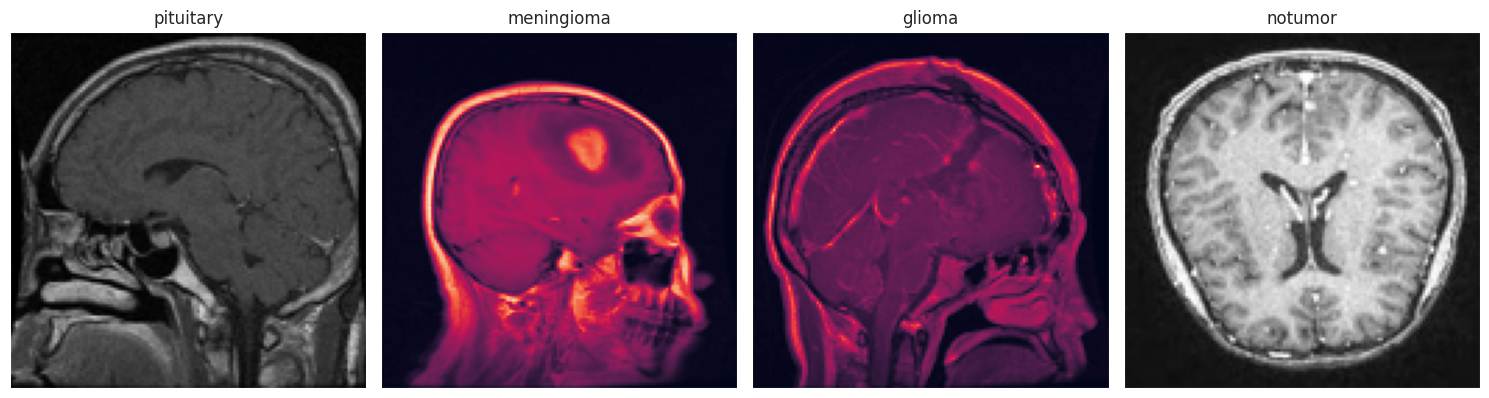

In [7]:
import matplotlib.pyplot as plt
from PIL import Image

class_samples = []

for label in test_df['label'].unique():
    sample = test_df[test_df['label'] == label].iloc[0]  
    class_samples.append((sample['image'], sample['label']))

target_size = (128, 128)  

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for ax, (filepath, label) in zip(axes, class_samples):
    img = Image.open(filepath)
    img_resized = img.resize(target_size)
    ax.imshow(img_resized)
    ax.set_title(label)

plt.tight_layout()
plt.savefig('Display_images.jpg', dpi=1200)
plt.show()

In [8]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')
        
        if accuracy:
            print(f"Epoch {epoch + 1}: Training accuracy is {accuracy:.4f}")
        if val_accuracy:
            print(f"Epoch {epoch + 1}: Validation accuracy is {val_accuracy:.4f}")
        
        if (accuracy and accuracy > 0.99) or (val_accuracy and val_accuracy > 0.99):
            print("\nReached 99% accuracy in training or validation, so cancelling training!")

# Model Using SeparableConv2D

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SeparableConv2D, MaxPooling2D, BatchNormalization, Dropout, GlobalAveragePooling2D, Dense, LeakyReLU

input_layer = Input(shape=(150, 150, 3))

x = SeparableConv2D(64, (3, 3), padding='same')(input_layer)
x = LeakyReLU(alpha=0.1)(x)
x = SeparableConv2D(64, (3, 3), padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)

x = SeparableConv2D(128, (3, 3), padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)
x = SeparableConv2D(128, (3, 3), padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)

x = SeparableConv2D(256, (3, 3), padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)
x = SeparableConv2D(256, (3, 3), padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = SeparableConv2D(512, (3, 3), padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = GlobalAveragePooling2D()(x)

x = Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.4)(x)

output_layer = Dense(4, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_7 (SeparableConv2D) │ (None, 150, 150, 64)        │             283 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 150, 150, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_8 (SeparableConv2D) │ (None, 150, 150, 64)        │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 150, 150, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_9 (SeparableConv2D) │ (None, 75, 75, 128)         │           8,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 75, 75, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_10                  │ (None, 75, 75, 128)         │          17,664 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 75, 75, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 37, 37, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_11                  │ (None, 37, 37, 256)         │          34,176 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_12 (LeakyReLU)           │ (None, 37, 37, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_12                  │ (None, 37, 37, 256)         │          68,096 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_13 (LeakyReLU)           │ (None, 37, 37, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 18, 18, 256)         │           1,0

 Total params: 403,935 (1.54 MB)

 Trainable params: 402,015 (1.53 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [12]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
import time

start_time = time.time()


def lr_scheduler(epoch, lr):
    new_lr = lr * tf.math.exp(-0.1)
    return float(new_lr.numpy())

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=5, 
    min_lr=0.0001
)

callbacks = [
    myCallback(),
    LearningRateScheduler(lr_scheduler),
    reduce_lr
]

model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(
    train_gen,
    epochs=50,
    batch_size=32,
    verbose=2,
    validation_data=valid_gen,
    callbacks=callbacks
)

end_time = time.time()
training_time = end_time - start_time
print(f"\nTotal training time: {training_time:.2f} seconds")
print(f"Time per epoch: {training_time/50:.2f} seconds")

Epoch 1/50
Epoch 1: Training accuracy is 0.6430
Epoch 1: Validation accuracy is 0.2347
143/143 - 74s - 515ms/step - accuracy: 0.6430 - loss: 0.9022 - val_accuracy: 0.2347 - val_loss: 1.4243 - learning_rate: 9.0484e-04
Epoch 2/50
Epoch 2: Training accuracy is 0.7264
Epoch 2: Validation accuracy is 0.3975
143/143 - 31s - 215ms/step - accuracy: 0.7264 - loss: 0.7247 - val_accuracy: 0.3975 - val_loss: 1.4545 - learning_rate: 8.1873e-04
Epoch 3/50
Epoch 3: Training accuracy is 0.7496
Epoch 3: Validation accuracy is 0.2557
143/143 - 31s - 219ms/step - accuracy: 0.7496 - loss: 0.6558 - val_accuracy: 0.2557 - val_loss: 1.7453 - learning_rate: 7.4082e-04
Epoch 4/50
Epoch 4: Training accuracy is 0.7951
Epoch 4: Validation accuracy is 0.2627
143/143 - 31s - 217ms/step - accuracy: 0.7951 - loss: 0.5646 - val_accuracy: 0.2627 - val_loss: 2.2446 - learning_rate: 6.7032e-04
Epoch 5/50
Epoch 5: Training accuracy is 0.8072
Epoch 5: Validation accuracy is 0.5219
143/143 - 32s - 221ms/step - accuracy: 0.

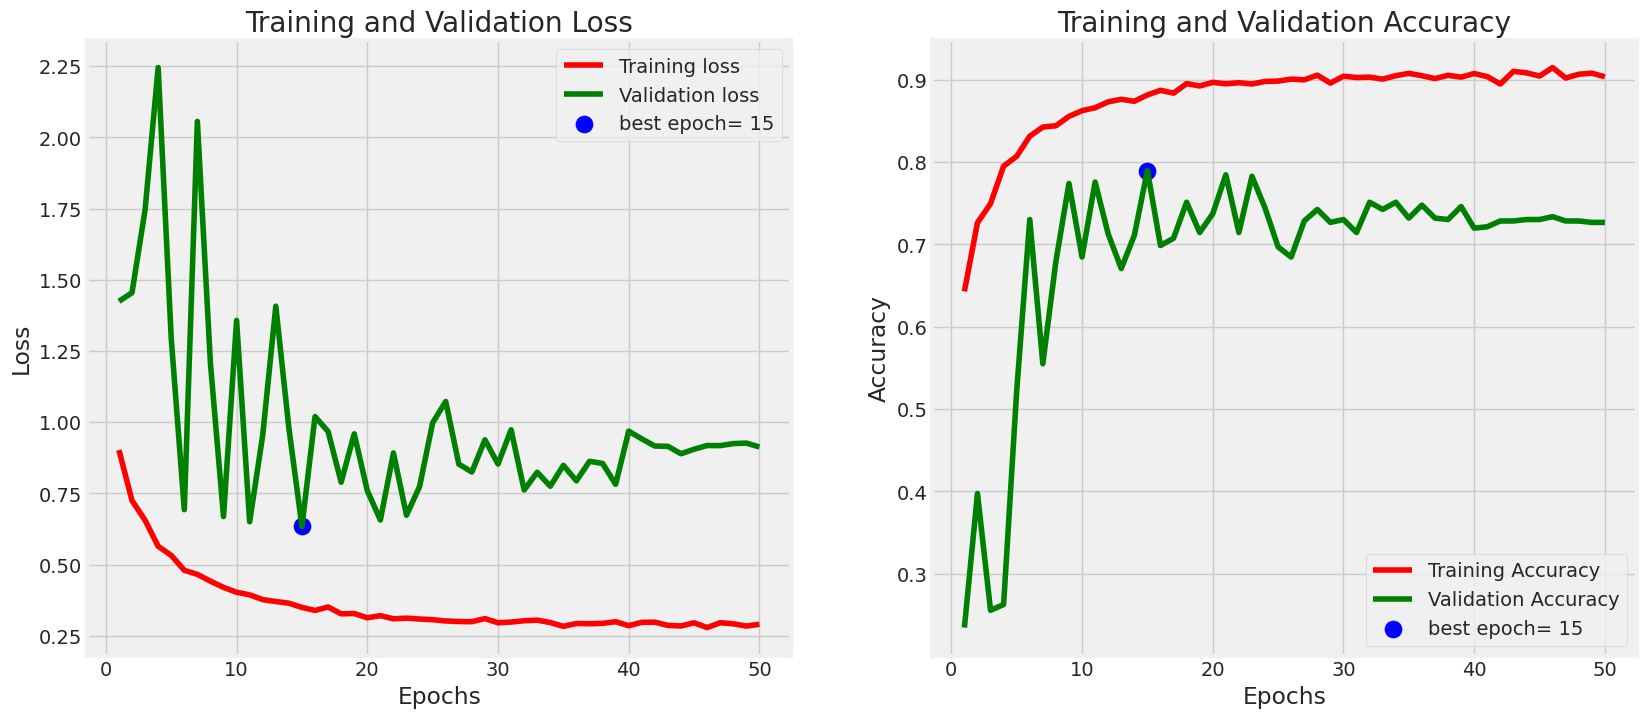

In [13]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout

plt.savefig('training_validation_plots.png')
plt.show()

In [14]:
loss, accuracy = model.evaluate(valid_gen)
print("Accuracy score:", accuracy)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.7140 - loss: 0.9397
Accuracy score: 0.7267950773239136


In [15]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step - accuracy: 0.9435 - loss: 0.2144
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.7062 - loss: 0.9518
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.7296 - loss: 0.8428
Train Loss:  0.24471727013587952
Train Accuracy:  0.9375
--------------------
Valid Loss:  0.9377312064170837
Valid Accuracy:  0.7244318127632141
--------------------
Test Loss:  0.9110929369926453
Test Accuracy:  0.7272727489471436


In [16]:
classes = list(test_gen.class_indices.keys())

preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

from sklearn.metrics import classification_report
print(classification_report(test_gen.classes, y_pred, target_names=classes))

18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 240ms/step
              precision    recall  f1-score   support

      glioma       0.94      0.67      0.78       132
  meningioma       0.88      0.32      0.47       134
     notumor       0.96      0.94      0.95       160
   pituitary       0.54      1.00      0.70       146

    accuracy                           0.75       572
   macro avg       0.83      0.73      0.73       572
weighted avg       0.83      0.75      0.73       572



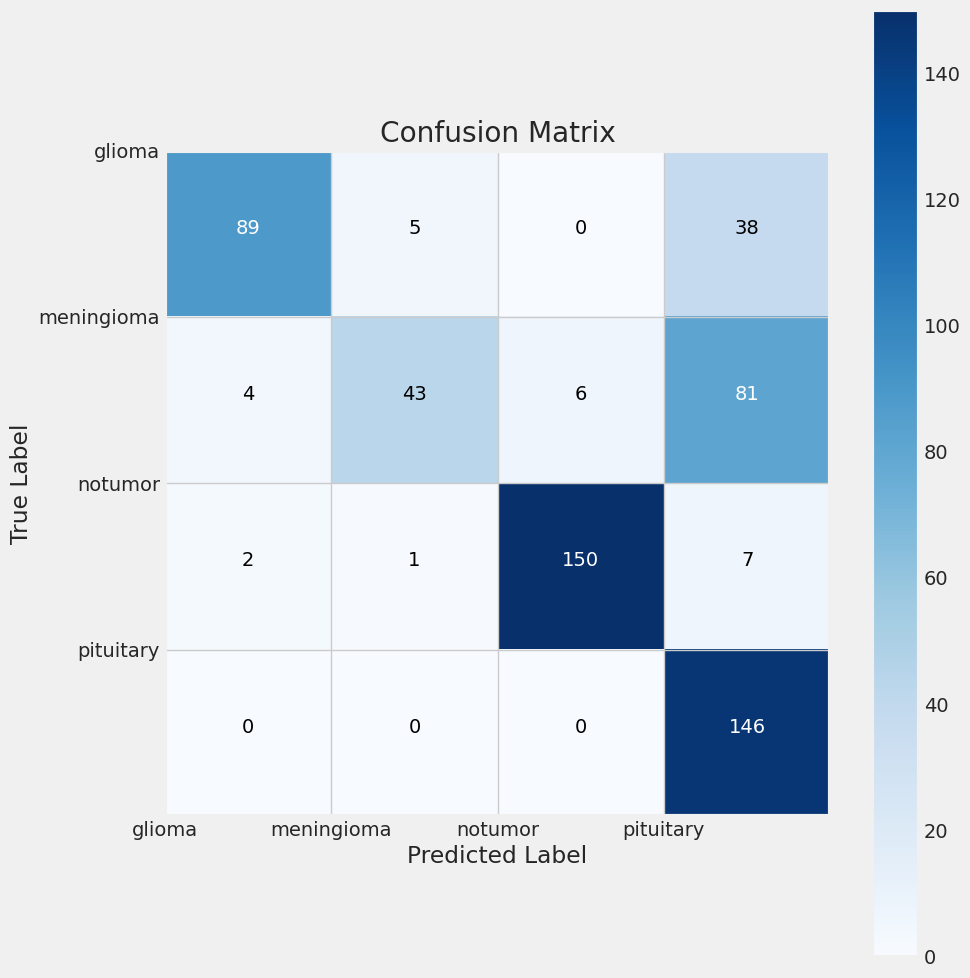

In [17]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks - 0.5, classes)  
plt.yticks(tick_marks - 0.5, classes) 


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.savefig('confusion_matrix.png')
plt.show()

# Now, Using Conv2d in the model

In [18]:
model = Sequential()

model.add(tf.keras.layers.InputLayer(input_shape=(150, 150, 3)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))  
model.add(BatchNormalization())


model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))  
model.add(BatchNormalization())


model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))  
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))  
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())  

model.add(Dropout(0.3))  

model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))


model.add(Dense(4, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))  



model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 146, 146, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 73, 73, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 73, 73, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 71, 71, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 69, 69, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 34, 34, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 34, 34, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 30, 30, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 15, 15, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 13, 13, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 11, 11, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 5, 5, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 3, 3, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 307,332 (1.17 MB)

 Trainable params: 306,692 (1.17 MB)

 Non-trainable params: 640 (2.50 KB)

In [19]:
import time

start_time = time.time()

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.98):
            print("\nReached 98% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_gen,
    epochs=50,
    batch_size=32,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[callbacks]
)

end_time = time.time()
training_time = end_time - start_time
print(f"\nTotal training time: {training_time:.2f} seconds")
print(f"Time per epoch: {training_time/50:.2f} seconds")

Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 56s 299ms/step - accuracy: 0.4579 - loss: 1.2810 - val_accuracy: 0.3993 - val_loss: 1.1835
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 32s 211ms/step - accuracy: 0.5771 - loss: 1.0300 - val_accuracy: 0.6077 - val_loss: 0.9027
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 31s 207ms/step - accuracy: 0.6138 - loss: 0.9241 - val_accuracy: 0.5779 - val_loss: 0.9977
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 32s 210ms/step - accuracy: 0.6540 - loss: 0.8699 - val_accuracy: 0.4939 - val_loss: 1.7170
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 31s 204ms/step - accuracy: 0.7063 - loss: 0.7566 - val_accuracy: 0.4764 - val_loss: 1.8027
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 31s 207ms/step - accuracy: 0.7279 - loss: 0.6990 - val_accuracy: 0.6095 - val_loss: 1.1204
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 31s 205ms/step - accuracy: 0.7484 - loss: 0.6580 - val_accuracy: 0.4816 - val_loss: 2.0046
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 32s 211ms/step - accuracy: 0.7599 - loss: 0

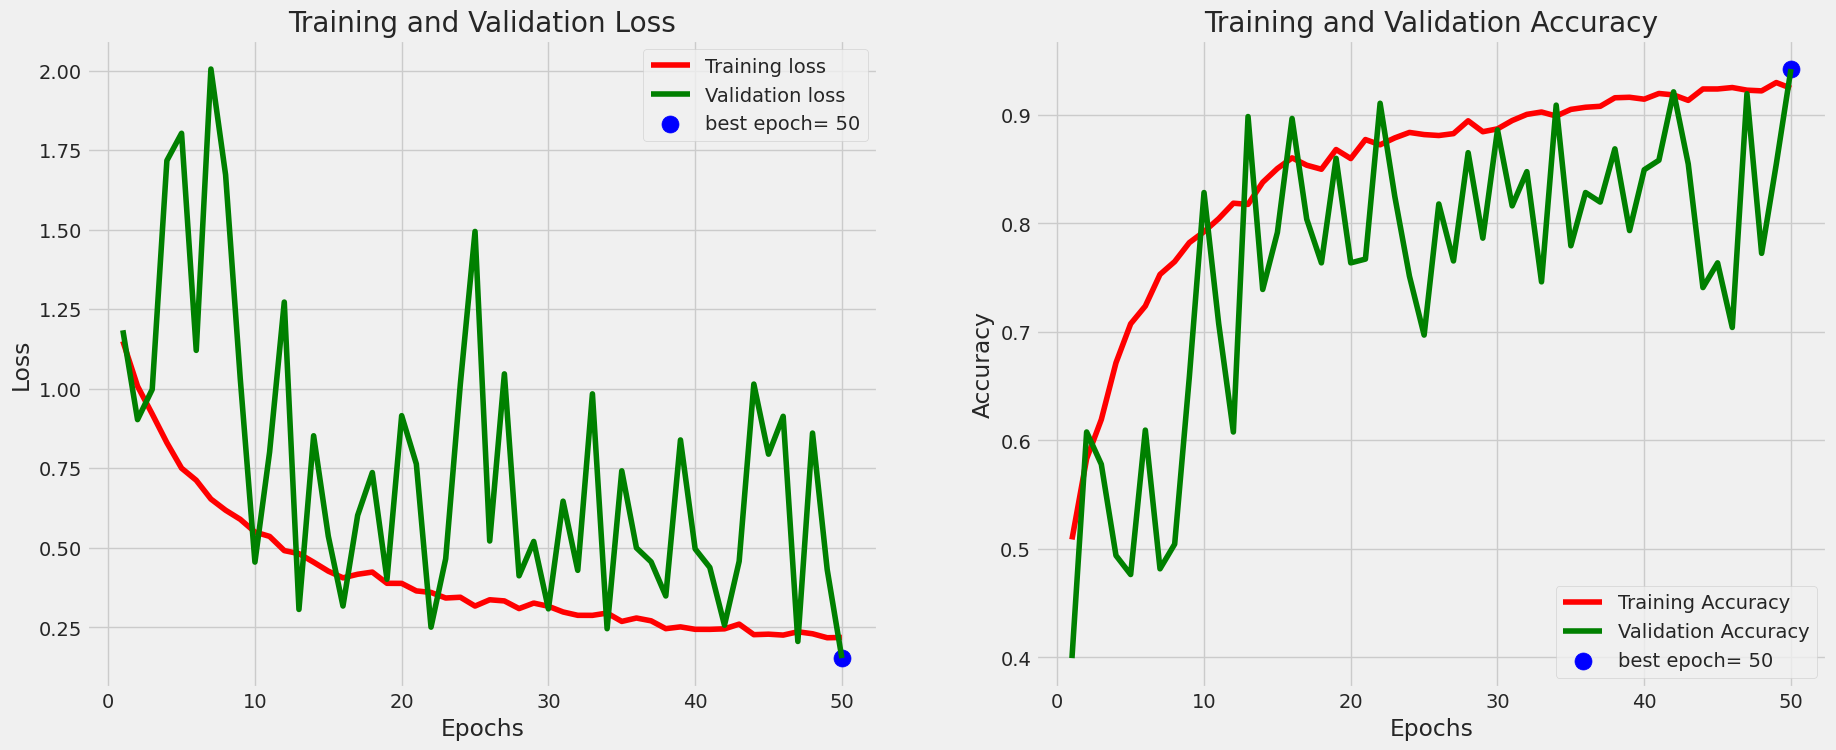

In [25]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [26]:
loss, accuracy = model.evaluate(valid_gen)
print("Accuracy score:", accuracy)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9322 - loss: 0.1660
Accuracy score: 0.9422066807746887


In [27]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - accuracy: 0.8827 - loss: 0.3435
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9262 - loss: 0.1775
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.9426 - loss: 0.1960
Train Loss:  0.3487285375595093
Train Accuracy:  0.8892045617103577
--------------------
Valid Loss:  0.1423603892326355
Valid Accuracy:  0.9431818127632141
--------------------
Test Loss:  0.1822427362203598
Test Accuracy:  0.9431818127632141


In [28]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

print(classification_report(test_gen.classes, y_pred, target_names= classes))


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
              precision    recall  f1-score   support

      glioma       1.00      0.91      0.95       132
  meningioma       0.90      0.91      0.90       134
     notumor       0.96      0.99      0.98       160
   pituitary       0.94      0.98      0.96       146

    accuracy                           0.95       572
   macro avg       0.95      0.95      0.95       572
weighted avg       0.95      0.95      0.95       572



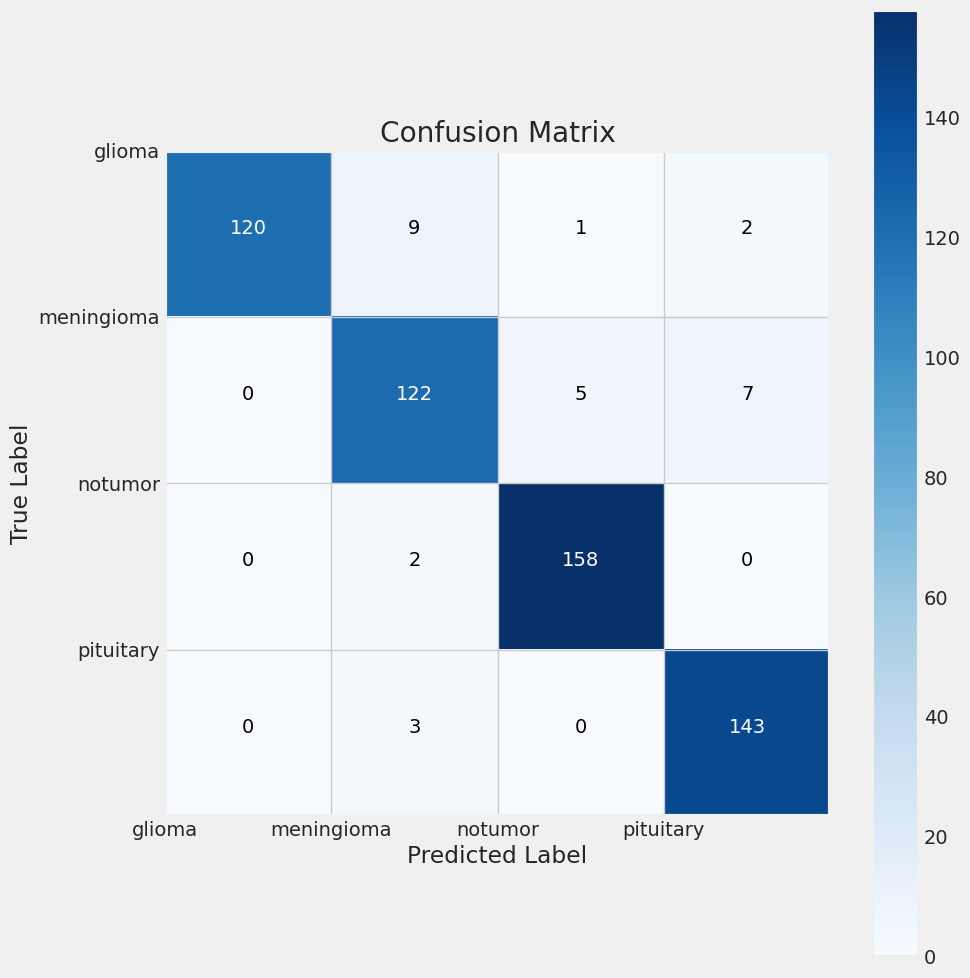

In [29]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks - 0.5, classes)  
plt.yticks(tick_marks - 0.5, classes) 


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

# Accuracy Performance
1. Conv2D achieved 94.3% test accuracy
2. SeparableConv2D achieved 72.7%

# Training Efficiency
1. Conv2D completed training in 1588 seconds (31.76s/epoch)
2. SeparableConv2D required 1625 seconds (32.50s/epoch)